efficientnet

3가지 loss

label은 3가지유형의 조합으로 구하기

### 26기준
### 변경부분 : 4가지의 loss( class, mask, gender, age) (V)

## 0. Libarary 불러오기 및 경로설정

In [1]:
import os
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize

In [2]:
train_dir = '/opt/ml/input/data/train'
test_dir = '/opt/ml/input/data/eval'

## 1. Custom Model 정의

## 2. Custom Dataset 정의

In [4]:
import numpy as np

class CustomDataset(Dataset):
    def __init__(self, img_paths, labels, masks, genders, ages, transform, device):
        """Initialize CustomDataset
        
        Parameters:
        img_paths (list of string): list of image paths
        labels (list of int): list of labels
        
        """
        self.img_paths = img_paths
        self.labels = torch.tensor(labels).to(device)
        self.masks = torch.tensor(masks).to(device)
        self.genders = torch.tensor(genders).to(device)
        self.ages = torch.tensor(ages).to(device)
        self.device = device
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])
        
        if self.transform:
            image = self.transform(image=np.array(image))['image']

        return image.to(self.device), (self.labels[index], self.masks[index], self.genders[index], self.ages[index])

    def __len__(self):
        return len(self.img_paths)

## 3. Model의 input data, label data 준비

In [6]:
import glob
import re

device = torch.device('cuda')
train_csv = pd.read_csv(os.path.join(train_dir, 'train.csv'))

# input data, output data 리스트 만들기(이미지 텐서화는 CustomDataset에서 이뤄짐)
train_image_paths = []
train_labels = []
train_masks = [] # mask:0 / incorrect:1 / notwear:2
train_genders = [] # male:0 / female:1
train_ages = [] # (,30):0 / [30, 60):1 / [60,):2 

dict_mask = {'mask1':0,
             'mask2':0,
             'mask3':0,
             'mask4':0,
             'mask5':0,
             'incorrect_mask':1,
             'normal':2,
            }

dict_gender = {'male':0,
              'female':1}

for i in range(train_csv.shape[0]): # number of train image folders is 2700
    row = train_csv.loc[i]
    seven_paths = glob.glob(train_dir + '/images/' + row['path'] + '/*.*')
    
    gender = row['gender']
    age = row['age']
    for i, path in enumerate(seven_paths):
        label = 0
        mask = path.split('/')[-1].split('.')[0]
        mask_label = dict_mask[mask]
        gender_label = dict_gender[gender]
        age_label = 0
        if 30 <= age < 60:
            age_label += 1
        elif 60 <= age:
            age_label += 2
            
        label = mask_label * 6 + gender_label * 3 + age_label        
                    
        train_image_paths.append(path)
        train_labels.append(label)
        train_masks.append(mask_label)
        train_genders.append(gender_label)
        train_ages.append(age_label)

In [7]:
print(len(train_image_paths))
print(len(train_labels))
print(len(train_masks))
print(len(train_genders))
print(len(train_ages))

print()
print(train_image_paths[5:10])
print(train_labels[5:10])
print(train_masks[5:10])
print(train_genders[5:10])
print(train_ages[5:10])

18900
18900
18900
18900
18900

['/opt/ml/input/data/train/images/000001_female_Asian_45/mask2.jpg', '/opt/ml/input/data/train/images/000001_female_Asian_45/mask4.jpg', '/opt/ml/input/data/train/images/000002_female_Asian_52/normal.jpg', '/opt/ml/input/data/train/images/000002_female_Asian_52/mask5.jpg', '/opt/ml/input/data/train/images/000002_female_Asian_52/incorrect_mask.jpg']
[4, 4, 16, 4, 10]
[0, 0, 2, 0, 1]
[1, 1, 1, 1, 1]
[1, 1, 1, 1, 1]


## Train / Val 데이터셋 나누기(1:9)

In [8]:
# label별로 몇개 있는지 확인
label_to_num = {}

for _, label in enumerate(train_labels):
    if label in label_to_num:
        label_to_num[label] += 1
    else:
        label_to_num[label] = 1

print(label_to_num)

{16: 817, 4: 4085, 10: 817, 13: 410, 1: 2050, 7: 410, 15: 732, 3: 3660, 9: 732, 12: 549, 0: 2745, 6: 549, 14: 83, 2: 415, 8: 83, 17: 109, 5: 545, 11: 109}


In [10]:
# key: label(int), value: list of index(int)
label_to_indexlist = {}
val_ratio = 0.2

val_image_paths, val_labels, val_masks, val_genders, val_ages = [], [], [], [], []
new_train_image_paths, new_train_labels, new_train_masks, new_train_genders, new_train_ages = [], [], [], [], []

for idx, label in enumerate(train_labels):
    if label in label_to_indexlist:
        label_to_indexlist[label].append(idx)
    else:
        label_to_indexlist[label] = [idx]
        
label_to_val_index_list = {}

for key in label_to_indexlist:
    num_val = int(len(label_to_indexlist[key]) * val_ratio)
    print(f'total: {len(label_to_indexlist[key])} / num_val: {num_val}')
    label_to_val_index_list[key] = label_to_indexlist[key][:num_val]

flags = [False] * len(train_image_paths)
for label in label_to_val_index_list:
    idxlist_val = label_to_val_index_list[label] # [int, int, int, int]
    for idx in idxlist_val:
        flags[idx] = True

for i, flag in enumerate(flags):
    if flag: # validation set으로 설정
        val_image_paths.append(train_image_paths[i])
        val_labels.append(train_labels[i])
        val_masks.append(train_masks[i])
        val_genders.append(train_genders[i])
        val_ages.append(train_ages[i])
        
    else:
        new_train_image_paths.append(train_image_paths[i])
        new_train_labels.append(train_labels[i])
        new_train_masks.append(train_masks[i])
        new_train_genders.append(train_genders[i])
        new_train_ages.append(train_ages[i])
        
train_image_paths = new_train_image_paths
train_labels = new_train_labels
train_masks = new_train_masks 
train_genders = new_train_genders
train_ages = new_train_ages

total: 817 / num_val: 163
total: 4085 / num_val: 817
total: 817 / num_val: 163
total: 410 / num_val: 82
total: 2050 / num_val: 410
total: 410 / num_val: 82
total: 732 / num_val: 146
total: 3660 / num_val: 732
total: 732 / num_val: 146
total: 549 / num_val: 109
total: 2745 / num_val: 549
total: 549 / num_val: 109
total: 83 / num_val: 16
total: 415 / num_val: 83
total: 83 / num_val: 16
total: 109 / num_val: 21
total: 545 / num_val: 109
total: 109 / num_val: 21


In [11]:
print(len(train_image_paths)) # 18900 * 0.8 = 15120 --> 15126
print(len(train_labels))
print(len(train_masks))
print(len(train_genders))
print(len(train_ages))

print(len(val_image_paths)) # 18900 * 0.2 = 3780 --> 3774
print(len(val_labels))
print(len(val_masks))
print(len(val_genders))
print(len(val_ages))

15126
15126
15126
15126
15126
3774
3774
3774
3774
3774


## 4. DataLoader 정의

In [13]:
# !pip install albumentations

In [ ]:
mean=(0.548, 0.504, 0.479)
std=(0.237, 0.247, 0.246)

transform = albumentations.Compose([
            #Resize(img_size[0], img_size[1], p=1.0),
            #Resize(200, 260, p=1.0),
            CenterCrop(height = 400, width = 200), # add centercrop 350/350 -> 400/200 -> 300/300
            #HorizontalFlip(p=0.5),
            #ShiftScaleRotate(p=0.5),
            #HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            #GaussNoise(p=0.5),
            Normalize(mean=mean, std=std, max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)

dataset = CustomDataset(train_image_paths, train_labels, train_masks, train_genders, train_ages, transform, device)
train_loader = DataLoader(dataset,
                    batch_size=32,
                    shuffle=True,
                    num_workers=0,
                    drop_last=True 
                   )

transform = albumentations.Compose([
            #Resize(img_size[0], img_size[1]),
            #Resize(200, 260),
            CenterCrop(height = 400, width = 200), # add centercrop
            Normalize(mean=mean, std=std, max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)

val_dataset = CustomDataset(val_image_paths, val_labels, val_masks, val_genders, val_ages, transform, device)
val_loader = DataLoader(val_dataset,
                    batch_size = 32,
                    shuffle=True,
                    num_workers=0
                   )

## 변환 후 이미지 확인

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 400, 200])
tensor(6, device='cuda:0')
tensor(1, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')


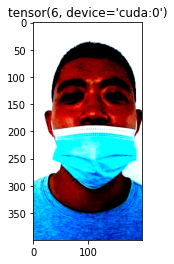

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

def custom_imshow(img, title):
    img = img.cpu().numpy()
    plt.imshow(img.transpose((1, 2, 0)))
    plt.title(title)
    
xs, (y1s, y2s, y3s, y4s) = next(iter(train_loader))
print(xs[2].shape)
print(y1s[2])
print(y2s[2])
print(y3s[2])
print(y4s[2])

img = torchvision.utils.make_grid(xs[2])
custom_imshow(img, title=y1s[2])

## 5. Accuracy 계산 함수 정의 및 Train

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# https://discuss.pytorch.org/t/is-this-a-correct-implementation-for-focal-loss-in-pytorch/43327/8
class FocalLoss(nn.Module):
    def __init__(self, weight=None,
                 gamma=2., reduction='mean'):
        nn.Module.__init__(self)
        self.weight = weight
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, input_tensor, target_tensor):
        log_prob = F.log_softmax(input_tensor, dim=-1)
        prob = torch.exp(log_prob)
        return F.nll_loss(
            ((1 - prob) ** self.gamma) * log_prob,
            target_tensor,
            weight=self.weight,
            reduction=self.reduction
        )
    
class F1Loss(nn.Module):
    def __init__(self, classes=18, epsilon=1e-7):
        super().__init__()
        self.classes = classes
        self.epsilon = epsilon
    def forward(self, y_pred, y_true):
        assert y_pred.ndim == 2
        assert y_true.ndim == 1
        y_true = F.one_hot(y_true, self.classes).to(torch.float32)
        y_pred = F.softmax(y_pred, dim=1)

        tp = (y_true * y_pred).sum(dim=0).to(torch.float32)
        tn = ((1 - y_true) * (1 - y_pred)).sum(dim=0).to(torch.float32)
        fp = ((1 - y_true) * y_pred).sum(dim=0).to(torch.float32)
        fn = (y_true * (1 - y_pred)).sum(dim=0).to(torch.float32)

        precision = tp / (tp + fp + self.epsilon)
        recall = tp / (tp + fn + self.epsilon)

        f1 = 2 * (precision * recall) / (precision + recall + self.epsilon)
        f1 = f1.clamp(min=self.epsilon, max=1 - self.epsilon)
        return 1 - f1.mean()


In [21]:
# !pip install adamp

In [23]:
# !pip install timm

In [24]:
import torch.optim as optim
import torchvision.models as models
from tqdm.auto import tqdm
import time
from adamp import AdamP
import timm

LEARNING_RATE = 3e-4
WEIGHT_DECAY = 1e-2 # https://paperswithcode.com/method/weight-decay

def func_acc(outputs, labels):
    cnt_answer = 0
    for i in range(len(labels)):
        label = labels[i]
        _, output = outputs[i].max(dim=0)
        if label == output:
            cnt_answer += 1
        
    return cnt_answer / len(labels)
 
    
def func_class_acc(outputs, labels, pre_acc_list):
    # return: [[True, False, ], [], [], ...]
    answer = [[] for i in range(18)]    
    
    is_answer = [[] for i in range(18)]
    for i in range(len(labels)):
        label = labels[i]
        _, output = outputs[i].max(dim=0)
        if label == output:
            is_answer[label].append(True)
        else:
            is_answer[label].append(False)
            
    for i in range(18):
        answer[i] = pre_acc_list[i] + is_answer[i]
                           
    return answer

def func_class_acc_mask(outputs, labels, pre_acc_list):
    # return: [[True, False, ], [], [], ...]
    answer = [[] for i in range(3)]    
    
    is_answer = [[] for i in range(3)]
    for i in range(len(labels)):
        label = labels[i]
        _, output = outputs[i].max(dim=0)
        if label == output:
            is_answer[label].append(True)
        else:
            is_answer[label].append(False)
            
    for i in range(3):
        answer[i] = pre_acc_list[i] + is_answer[i]
                           
    return answer

def func_class_acc_gender(outputs, labels, pre_acc_list):
    # return: [[True, False, ], [], [], ...]
    answer = [[] for i in range(2)]    
    
    is_answer = [[] for i in range(2)]
    for i in range(len(labels)):
        label = labels[i]
        _, output = outputs[i].max(dim=0)
        if label == output:
            is_answer[label].append(True)
        else:
            is_answer[label].append(False)
            
    for i in range(2):
        answer[i] = pre_acc_list[i] + is_answer[i]
                           
    return answer

def func_class_acc_age(outputs, labels, pre_acc_list):
    # return: [[True, False, ], [], [], ...]
    answer = [[] for i in range(3)]    
    
    is_answer = [[] for i in range(3)]
    for i in range(len(labels)):
        label = labels[i]
        _, output = outputs[i].max(dim=0)
        if label == output:
            is_answer[label].append(True)
        else:
            is_answer[label].append(False)
            
    for i in range(3):
        answer[i] = pre_acc_list[i] + is_answer[i]
                           
    return answer

def cal_class_acc(epoch_class_acc):
    output = [0] * 18
    for i in range(18):
        total_cnt = len(epoch_class_acc[i])
        answer_cnt = 0
        for answer in epoch_class_acc[i]:
            if answer:
                answer_cnt += 1
        output[i] = answer_cnt / total_cnt
    return output

def cal_class_acc_mask(epoch_class_acc):
    output = [0] * 3
    for i in range(3):
        total_cnt = len(epoch_class_acc[i])
        answer_cnt = 0
        for answer in epoch_class_acc[i]:
            if answer:
                answer_cnt += 1
        output[i] = answer_cnt / total_cnt
    return output

def cal_class_acc_gender(epoch_class_acc):
    output = [0] * 2
    for i in range(2):
        total_cnt = len(epoch_class_acc[i])
        answer_cnt = 0
        for answer in epoch_class_acc[i]:
            if answer:
                answer_cnt += 1
        output[i] = answer_cnt / total_cnt
    return output

def cal_class_acc_age(epoch_class_acc):
    output = [0] * 3
    for i in range(3):
        total_cnt = len(epoch_class_acc[i])
        answer_cnt = 0
        for answer in epoch_class_acc[i]:
            if answer:
                answer_cnt += 1
        output[i] = answer_cnt / total_cnt
    return output


def func_labels(outputs_mask, outputs_gender, outputs_age, device):
    # outputs_label = [class1, class2, class3, ...]
    outputs_label = torch.Tensor([])
    len_outputs = len(outputs_mask)
    for i in range(len_outputs):
        mask_class = outputs_mask[i] # [0.6, 0.2, 0.1, 0.1]
        _, mask_class = mask_class.max(dim=0)
        
        gender_class = outputs_gender[i] # [0.6, 0.2, 0.1, 0.1]
        _, gender_class = gender_class.max(dim=0)
        
        age_class = outputs_age[i] # [0.6, 0.2, 0.1, 0.1]
        _, age_class = age_class.max(dim=0)
        
        label = mask_class * 6 + gender_class * 3 + age_class
        
        #label: int -> [[1, 0, 0, 0]]
        one_hot = torch.zeros((1,18))
        one_hot[0][label] = 1
        label = one_hot
        outputs_label = torch.cat([outputs_label, label])
    return outputs_label.to(device)     


class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
#         self.model = models.resnet50(pretrained=True).to(device)
        self.model = timm.create_model('tf_efficientnet_b4', pretrained=True)
        self.model.classifier = nn.Linear(1792, 1024)
        self.fc1 = nn.Linear(1024, 3)
        self.fc2 = nn.Linear(1024, 2)
        self.fc3 = nn.Linear(1024, 3)
    
    def forward(self, x):
        fc_output = self.model(x)
        mask = self.fc1(fc_output)
        gender = self.fc2(fc_output)
        age = self.fc3(fc_output)
        
        return mask, gender, age      

model = MyModel().to(device)
    
# criterion = nn.CrossEntropyLoss()
criterion = FocalLoss(gamma = 5)
# criterion = F1Loss()

# optimizer = optim.Adam(model.parameters(), lr=1e-3)
optimizer = AdamP(model.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999), weight_decay= WEIGHT_DECAY)
# optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)


min_loss = float('inf')

for epoch in range(10):
    epoch_loss = 0
    epoch_acc = 0
    epoch_val_loss = 0
    epoch_val_acc = 0

    epoch_class_acc = [[] for i in range(18)]
    epoch_class_val_acc = [[] for i in range(18)]
    
    epoch_mask_acc = [[] for i in range(18)]
    epoch_mask_val_acc = [[] for i in range(18)]
    
    epoch_gender_acc = [[] for i in range(18)]
    epoch_gender_val_acc = [[] for i in range(18)]
    
    epoch_age_acc = [[] for i in range(18)]
    epoch_age_val_acc = [[] for i in range(18)]
    
    
    for i, data in tqdm(enumerate(train_loader), desc=f"epoch-{epoch}", total=len(train_loader)):
        inputs, (labels, masks, genders, ages) = data

        optimizer.zero_grad()
        outputs_mask, outputs_gender, outputs_age = model(inputs)
        outputs_label = func_labels(outputs_mask, outputs_gender, outputs_age, device)
        
        loss_masks = criterion(outputs_mask, masks)
        loss_genders = criterion(outputs_gender, genders)
        loss_ages = criterion(outputs_age, ages)
        
        loss = loss_masks + loss_genders + loss_ages
        
        epoch_loss += loss
        
        acc = func_acc(outputs_label, labels)
        epoch_acc += acc     
        
        epoch_class_acc = func_class_acc(outputs_label, labels, epoch_class_acc)
        
        epoch_mask_acc = func_class_acc_mask(outputs_mask, masks, epoch_mask_acc)
        epoch_gender_acc = func_class_acc_gender(outputs_gender, genders, epoch_gender_acc)
        epoch_age_acc = func_class_acc_age(outputs_age, ages, epoch_age_acc)
        
        loss.backward()
        optimizer.step()
        
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            val_inputs, (val_labels, val_masks, val_genders, val_ages) = data
            val_outputs_mask, val_outputs_gender, val_outputs_age = model(val_inputs)
            val_outputs_label = func_labels(val_outputs_mask, val_outputs_gender, val_outputs_age, device)
            
            val_loss_mask = criterion(val_outputs_mask, val_masks)
            val_loss_gender = criterion(val_outputs_gender, val_genders)
            val_loss_age = criterion(val_outputs_age, val_ages)
            val_loss = val_loss_mask + val_loss_gender + val_loss_age
        
            epoch_val_loss += val_loss

            val_acc = func_acc(val_outputs_label, val_labels)
            epoch_val_acc += val_acc

            epoch_class_val_acc = func_class_acc(val_outputs_label, val_labels, epoch_class_val_acc)
            epoch_mask_val_acc = func_class_acc_mask(val_outputs_mask, val_masks, epoch_mask_val_acc)
            epoch_gender_val_acc = func_class_acc_gender(val_outputs_gender, val_genders, epoch_gender_val_acc)
            epoch_age_val_acc = func_class_acc_age(val_outputs_age, val_ages, epoch_age_val_acc)



    epoch_loss /= len(train_loader)
    epoch_acc /= len(train_loader)
    epoch_class_acc = cal_class_acc(epoch_class_acc)
    
    epoch_mask_acc = cal_class_acc_mask(epoch_mask_acc)
    epoch_gender_acc = cal_class_acc_gender(epoch_gender_acc)
    epoch_age_acc = cal_class_acc_age(epoch_age_acc)
    

    if min_loss > epoch_loss:
        save_path = f'./save_model/epoch_{epoch+1}_loss_{epoch_loss}.pth'
        torch.save(model.state_dict(), save_path)
        min_loss = epoch_loss
    
    print(f'epoch: {epoch}, epoch_acc: {epoch_acc}, epoch_loss: {epoch_loss}')

    epoch_val_loss /= len(val_loader)
    epoch_val_acc /= len(val_loader)
    epoch_class_val_acc = cal_class_acc(epoch_class_val_acc)
    epoch_mask_val_acc = cal_class_acc_mask(epoch_mask_val_acc)
    epoch_gender_val_acc = cal_class_acc_gender(epoch_gender_val_acc)
    epoch_age_val_acc = cal_class_acc_age(epoch_age_val_acc)
    '''
    epoch_class_acc   epoch_class_val_acc
    epoch_mask_acc    epoch_mask_val_acc
    epoch_gender_acc   epoch_gender_val_acc
    epoch_age_acc   epoch_age_val_acc
    '''
    
    print(f'epoch: {epoch}, epoch_val_acc: {epoch_val_acc}, epoch_loss: {epoch_val_loss}')    
    print(f'epoch_class_acc:')
    for class_id in range(18):
        print(f'class{class_id}: {epoch_class_acc[class_id]:.3f}(train_label) / {epoch_class_val_acc[class_id]:.3f}(val_label)')
    
    print()
    print(f'epoch_mask_acc:')
    for class_id in range(3):
        print(f'class{class_id}: {epoch_mask_acc[class_id]:.3f}(train_mask) / {epoch_mask_val_acc[class_id]:.3f}(val_mask)')
    
    print()
    print(f'epoch_gender_acc:')
    for class_id in range(2):
        print(f'class{class_id}: {epoch_gender_acc[class_id]:.3f}(train_gender) / {epoch_gender_val_acc[class_id]:.3f}(val_gender)')                
    
    print()
    print(f'epoch_age_acc:')
    for class_id in range(3):
        print(f'class{class_id}: {epoch_age_acc[class_id]:.3f}(train_age) / {epoch_age_val_acc[class_id]:.3f}(val_age)')


epoch: 0, epoch_acc: 0.8631488347457628, epoch_loss: 0.02505863457918167
epoch: 0, epoch_val_acc: 0.8407309322033898, epoch_loss: 0.04656791314482689
epoch_class_acc:
class0: 0.914(train_label) / 0.845(val_label)
class1: 0.840(train_label) / 0.727(val_label)
class2: 0.636(train_label) / 0.265(val_label)
class3: 0.927(train_label) / 0.925(val_label)
class4: 0.872(train_label) / 0.927(val_label)
class5: 0.665(train_label) / 0.560(val_label)
class6: 0.832(train_label) / 0.908(val_label)
class7: 0.765(train_label) / 0.610(val_label)
class8: 0.642(train_label) / 0.438(val_label)
class9: 0.886(train_label) / 0.945(val_label)
class10: 0.828(train_label) / 0.730(val_label)
class11: 0.477(train_label) / 0.571(val_label)
class12: 0.879(train_label) / 0.963(val_label)
class13: 0.802(train_label) / 0.793(val_label)
class14: 0.597(train_label) / 0.375(val_label)
class15: 0.906(train_label) / 0.925(val_label)
class16: 0.874(train_label) / 0.890(val_label)
class17: 0.591(train_label) / 0.619(val_lab


epoch: 1, epoch_acc: 0.9521318855932204, epoch_loss: 0.008112248964607716
epoch: 1, epoch_val_acc: 0.8442090395480225, epoch_loss: 0.05824316293001175
epoch_class_acc:
class0: 0.969(train_label) / 0.891(val_label)
class1: 0.944(train_label) / 0.712(val_label)
class2: 0.906(train_label) / 0.301(val_label)
class3: 0.972(train_label) / 0.929(val_label)
class4: 0.960(train_label) / 0.930(val_label)
class5: 0.908(train_label) / 0.550(val_label)
class6: 0.950(train_label) / 0.734(val_label)
class7: 0.942(train_label) / 0.659(val_label)
class8: 0.866(train_label) / 0.312(val_label)
class9: 0.966(train_label) / 0.877(val_label)
class10: 0.904(train_label) / 0.828(val_label)
class11: 0.761(train_label) / 0.524(val_label)
class12: 0.957(train_label) / 0.917(val_label)
class13: 0.920(train_label) / 0.805(val_label)
class14: 0.821(train_label) / 0.312(val_label)
class15: 0.968(train_label) / 0.890(val_label)
class16: 0.949(train_label) / 0.945(val_label)
class17: 0.807(train_label) / 0.571(val_la


epoch: 2, epoch_acc: 0.973384533898305, epoch_loss: 0.004374970681965351
epoch: 2, epoch_val_acc: 0.7257768361581921, epoch_loss: 0.10240369290113449
epoch_class_acc:
class0: 0.985(train_label) / 0.809(val_label)
class1: 0.970(train_label) / 0.493(val_label)
class2: 0.924(train_label) / 0.265(val_label)
class3: 0.987(train_label) / 0.837(val_label)
class4: 0.981(train_label) / 0.946(val_label)
class5: 0.922(train_label) / 0.321(val_label)
class6: 0.966(train_label) / 0.807(val_label)
class7: 0.948(train_label) / 0.280(val_label)
class8: 0.896(train_label) / 0.500(val_label)
class9: 0.961(train_label) / 0.438(val_label)
class10: 0.965(train_label) / 0.540(val_label)
class11: 0.875(train_label) / 0.571(val_label)
class12: 0.973(train_label) / 0.899(val_label)
class13: 0.951(train_label) / 0.646(val_label)
class14: 0.910(train_label) / 0.375(val_label)
class15: 0.983(train_label) / 0.363(val_label)
class16: 0.974(train_label) / 0.908(val_label)
class17: 0.943(train_label) / 0.429(val_lab


epoch: 3, epoch_acc: 0.9553098516949152, epoch_loss: 0.00892241857945919
epoch: 3, epoch_val_acc: 0.8330861581920903, epoch_loss: 0.07947135716676712
epoch_class_acc:
class0: 0.980(train_label) / 0.903(val_label)
class1: 0.941(train_label) / 0.763(val_label)
class2: 0.910(train_label) / 0.590(val_label)
class3: 0.974(train_label) / 0.788(val_label)
class4: 0.962(train_label) / 0.934(val_label)
class5: 0.922(train_label) / 0.523(val_label)
class6: 0.941(train_label) / 0.908(val_label)
class7: 0.930(train_label) / 0.610(val_label)
class8: 0.851(train_label) / 0.438(val_label)
class9: 0.952(train_label) / 0.884(val_label)
class10: 0.930(train_label) / 0.828(val_label)
class11: 0.898(train_label) / 0.429(val_label)
class12: 0.952(train_label) / 0.899(val_label)
class13: 0.905(train_label) / 0.634(val_label)
class14: 0.866(train_label) / 0.500(val_label)
class15: 0.959(train_label) / 0.945(val_label)
class16: 0.951(train_label) / 0.939(val_label)
class17: 0.841(train_label) / 0.524(val_lab


epoch: 4, epoch_acc: 0.983249470338983, epoch_loss: 0.00294407713226974
epoch: 4, epoch_val_acc: 0.8385946327683615, epoch_loss: 0.07512806355953217
epoch_class_acc:
class0: 0.989(train_label) / 0.925(val_label)
class1: 0.985(train_label) / 0.815(val_label)
class2: 0.939(train_label) / 0.205(val_label)
class3: 0.991(train_label) / 0.859(val_label)
class4: 0.990(train_label) / 0.974(val_label)
class5: 0.963(train_label) / 0.339(val_label)
class6: 0.970(train_label) / 0.826(val_label)
class7: 0.966(train_label) / 0.634(val_label)
class8: 0.881(train_label) / 0.250(val_label)
class9: 0.978(train_label) / 0.610(val_label)
class10: 0.980(train_label) / 0.822(val_label)
class11: 0.943(train_label) / 0.286(val_label)
class12: 0.977(train_label) / 0.936(val_label)
class13: 0.970(train_label) / 0.744(val_label)
class14: 0.910(train_label) / 0.312(val_label)
class15: 0.986(train_label) / 0.932(val_label)
class16: 0.989(train_label) / 0.982(val_label)
class17: 0.943(train_label) / 0.238(val_labe


epoch: 5, epoch_acc: 0.9777542372881356, epoch_loss: 0.0036638604942709208
epoch: 5, epoch_val_acc: 0.829590395480226, epoch_loss: 0.07730168104171753
epoch_class_acc:
class0: 0.987(train_label) / 0.909(val_label)
class1: 0.980(train_label) / 0.798(val_label)
class2: 0.955(train_label) / 0.337(val_label)
class3: 0.989(train_label) / 0.783(val_label)
class4: 0.984(train_label) / 0.928(val_label)
class5: 0.947(train_label) / 0.560(val_label)
class6: 0.973(train_label) / 0.936(val_label)
class7: 0.960(train_label) / 0.646(val_label)
class8: 0.896(train_label) / 0.375(val_label)
class9: 0.974(train_label) / 0.870(val_label)
class10: 0.960(train_label) / 0.822(val_label)
class11: 0.909(train_label) / 0.571(val_label)
class12: 0.986(train_label) / 0.945(val_label)
class13: 0.948(train_label) / 0.537(val_label)
class14: 0.910(train_label) / 0.500(val_label)
class15: 0.986(train_label) / 0.938(val_label)
class16: 0.962(train_label) / 0.890(val_label)
class17: 0.886(train_label) / 0.667(val_la


epoch: 6, epoch_acc: 0.9741790254237288, epoch_loss: 0.004753510933369398
epoch: 6, epoch_val_acc: 0.8540077683615819, epoch_loss: 0.08445803821086884
epoch_class_acc:
class0: 0.984(train_label) / 0.916(val_label)
class1: 0.977(train_label) / 0.751(val_label)
class2: 0.927(train_label) / 0.482(val_label)
class3: 0.983(train_label) / 0.846(val_label)
class4: 0.974(train_label) / 0.957(val_label)
class5: 0.952(train_label) / 0.615(val_label)
class6: 0.966(train_label) / 0.917(val_label)
class7: 0.976(train_label) / 0.659(val_label)
class8: 0.881(train_label) / 0.250(val_label)
class9: 0.981(train_label) / 0.836(val_label)
class10: 0.968(train_label) / 0.840(val_label)
class11: 0.874(train_label) / 0.571(val_label)
class12: 0.984(train_label) / 0.945(val_label)
class13: 0.963(train_label) / 0.707(val_label)
class14: 0.910(train_label) / 0.375(val_label)
class15: 0.983(train_label) / 0.945(val_label)
class16: 0.976(train_label) / 0.963(val_label)
class17: 0.852(train_label) / 0.619(val_la


epoch: 7, epoch_acc: 0.9805349576271186, epoch_loss: 0.004159714560955763
epoch: 7, epoch_val_acc: 0.8495233050847458, epoch_loss: 0.08774249255657196
epoch_class_acc:
class0: 0.984(train_label) / 0.913(val_label)
class1: 0.976(train_label) / 0.773(val_label)
class2: 0.964(train_label) / 0.542(val_label)
class3: 0.991(train_label) / 0.855(val_label)
class4: 0.983(train_label) / 0.929(val_label)
class5: 0.959(train_label) / 0.615(val_label)
class6: 0.968(train_label) / 0.917(val_label)
class7: 0.973(train_label) / 0.610(val_label)
class8: 0.970(train_label) / 0.375(val_label)
class9: 0.978(train_label) / 0.890(val_label)
class10: 0.977(train_label) / 0.798(val_label)
class11: 0.977(train_label) / 0.667(val_label)
class12: 0.954(train_label) / 0.936(val_label)
class13: 0.970(train_label) / 0.756(val_label)
class14: 0.970(train_label) / 0.375(val_label)
class15: 0.985(train_label) / 0.870(val_label)
class16: 0.988(train_label) / 0.933(val_label)
class17: 0.966(train_label) / 0.571(val_la


epoch: 8, epoch_acc: 0.9773569915254238, epoch_loss: 0.00421962421387434
epoch: 8, epoch_val_acc: 0.8280190677966102, epoch_loss: 0.07447154074907303
epoch_class_acc:
class0: 0.980(train_label) / 0.860(val_label)
class1: 0.974(train_label) / 0.824(val_label)
class2: 0.949(train_label) / 0.361(val_label)
class3: 0.987(train_label) / 0.818(val_label)
class4: 0.982(train_label) / 0.942(val_label)
class5: 0.936(train_label) / 0.477(val_label)
class6: 0.975(train_label) / 0.890(val_label)
class7: 0.951(train_label) / 0.671(val_label)
class8: 0.896(train_label) / 0.312(val_label)
class9: 0.990(train_label) / 0.733(val_label)
class10: 0.982(train_label) / 0.822(val_label)
class11: 0.920(train_label) / 0.429(val_label)
class12: 0.984(train_label) / 0.945(val_label)
class13: 0.960(train_label) / 0.841(val_label)
class14: 0.910(train_label) / 0.500(val_label)
class15: 0.981(train_label) / 0.815(val_label)
class16: 0.979(train_label) / 0.902(val_label)
class17: 0.943(train_label) / 0.524(val_lab


epoch: 9, epoch_acc: 0.9938426906779662, epoch_loss: 0.0008080923580564559
epoch: 9, epoch_val_acc: 0.8719632768361582, epoch_loss: 0.12183218449354172
epoch_class_acc:
class0: 0.993(train_label) / 0.931(val_label)
class1: 0.994(train_label) / 0.773(val_label)
class2: 0.994(train_label) / 0.373(val_label)
class3: 0.995(train_label) / 0.941(val_label)
class4: 0.996(train_label) / 0.936(val_label)
class5: 0.989(train_label) / 0.523(val_label)
class6: 0.991(train_label) / 0.927(val_label)
class7: 0.985(train_label) / 0.768(val_label)
class8: 1.000(train_label) / 0.312(val_label)
class9: 0.997(train_label) / 0.904(val_label)
class10: 0.994(train_label) / 0.853(val_label)
class11: 0.977(train_label) / 0.476(val_label)
class12: 0.995(train_label) / 0.927(val_label)
class13: 0.988(train_label) / 0.744(val_label)
class14: 0.985(train_label) / 0.438(val_label)
class15: 0.993(train_label) / 0.938(val_label)
class16: 0.995(train_label) / 0.951(val_label)
class17: 1.000(train_label) / 0.476(val_l

0: 2745<br/>
1: 2050<br/>
2: 415<br/>
3: 3660<br/>
4: 4085<br/>
5: 545<br/>
6: 549<br/>
7: 410<br/>
8: 83<br/>
9: 732<br/>
10: 817<br/>
11: 109<br/>
12: 549<br/>
13: 410<br/>
14: 83<br/>
15: 732<br/>
16: 817<br/>
17: 109<br/>

총이미지: 2700 * 3 배치사이즈: 32 한 epoch당 253번의 iteration 발생<br/>
총이미지: 2700 * 3 배치사이즈: 64 한 epoch당 126번의 iteration 발생<br/>
총이미지: 2700 * 3 배치사이즈: 128 한 epoch당 63번의 iteration 발생<br/>
총이미지: 2700 * 3 배치사이즈: 256 한 epoch당 31번의 iteration 발생<br/>

총이미지: 18828 배치사이즈:256 한 epoch당 74번의 iteration 발생

## 6. Inference

In [25]:
class TestDataset(Dataset):
    def __init__(self, img_paths, transform, device):
        self.img_paths = img_paths
        self.device = device
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])
        
        if self.transform:
            image = self.transform(image=np.array(image))['image']

        return image.to(self.device)

    def __len__(self):
        return len(self.img_paths)


    
# meta 데이터와 이미지 경로를 불러옵니다.
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')

# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]
transform = albumentations.Compose([
            #Resize(img_size[0], img_size[1]),
            #Resize(200, 260),
            CenterCrop(height = 400, width = 200), # add centercrop
            Normalize(mean=mean, std=std, max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)
dataset = TestDataset(image_paths, transform, device)

loader = DataLoader(
    dataset,
    shuffle=False
)

# 모델을 정의합니다. (학습한 모델이 있다면 torch.load로 모델을 불러주세요!)
device = torch.device('cuda')

model = MyModel().to(device)

path = './미제출_34_save_model/epoch_10_loss_0.0008080923580564559.pth'
model.load_state_dict(torch.load(path))
model.eval()

# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []
for images in loader:
    with torch.no_grad():
        images = images.to(device)
        '''
        val_outputs_mask, val_outputs_gender, val_outputs_age = model(val_inputs)
        val_outputs_label = func_labels(val_outputs_mask, val_outputs_gender, val_outputs_age, device)
        '''
        pred_outputs_mask, pred_outputs_gender, pred_outputs_age = model(images)
        pred = func_labels(pred_outputs_mask, pred_outputs_gender, pred_outputs_age, device)
    
        pred = pred.argmax(dim=-1)
        all_predictions.extend(pred.cpu().numpy())
submission['ans'] = all_predictions

# 제출할 파일을 저장합니다.
submission.to_csv(os.path.join(test_dir, 'submission.csv'), index=False)
print('test inference is done!')